In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

2024-06-05 19:15:04.107623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import mydata as md

data = md.Data('cache')


In [3]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('kinopoisk')

In [4]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [5]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

2024-06-05 19:16:09.009764: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [7]:
ltsm_embedding_dim=32

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=ltsm_embedding_dim,
    mask_zero=True
)
bidirectional_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
dense_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None)

model_lstm = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    bidirectional_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, kernel_regularizer='l2')
])
model_lstm.summary()

model_lstm.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 32)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 690,051 (2.63 MB)

 Trainable params: 690,051 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [9]:
checkpoint_filepath = "models/checkpoint_kinopoisk_model_lstm.weights.h5"

epochs = 10
history = model_lstm.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        )        
    ]
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - F1Score: 0.3373 - accuracy: 0.3636 - loss: 1.1219 - val_F1Score: 0.3707 - val_accuracy: 0.4640 - val_loss: 1.0978
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - F1Score: 0.4554 - accuracy: 0.5287 - loss: 0.9832 - val_F1Score: 0.5218 - val_accuracy: 0.5800 - val_loss: 0.9202
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - F1Score: 0.5510 - accuracy: 0.5971 - loss: 0.8678 - val_F1Score: 0.5924 - val_accuracy: 0.6087 - val_loss: 0.8619
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - F1Score: 0.5770 - accuracy: 0.6179 - loss: 0.8108 - val_F1Score: 0.5832 - val_accuracy: 0.6087 - val_loss: 0.8467
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - F1Score: 0.6139 - accuracy: 0.6435 - loss: 0.7715 - val_F1Score: 0.5233 - val_accuracy: 0.6073 - val_loss: 0.8728
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - F1Score: 0.6453 - accuracy: 0.6776 - loss: 0.7266 - val_F1Score: 0.5419 - val_accuracy: 0.6107 - val

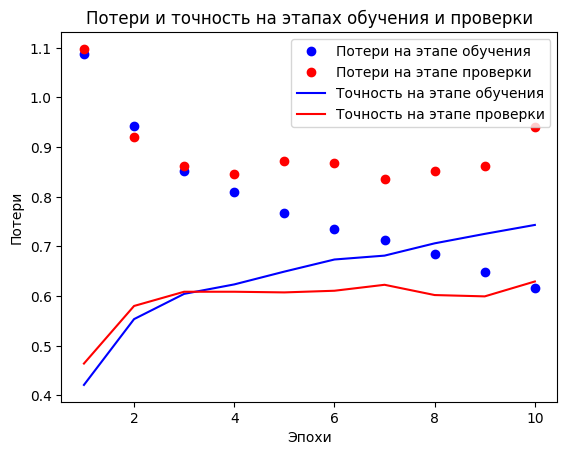

In [10]:
data.plot(history)

In [11]:
model_lstm.load_weights(checkpoint_filepath)

In [12]:
model_lstm.evaluate(test_ds_batch)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - F1Score: 0.5684 - accuracy: 0.6199 - loss: 0.9803


[0.9713464975357056,
 0.6193333268165588,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7256917 , 0.2678571 , 0.71495765], dtype=float32)>]

In [13]:
embedding_layer.trainable=False
bidirectional_layer.trainable=False

model_lstm_step2 = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    bidirectional_layer,
    tf.keras.layers.Dropout(0.2),
    dense_layer,
    tf.keras.layers.Dense(3, kernel_regularizer='l2')
])
model_lstm_step2.summary()

model_lstm_step2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 32)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,115 (2.66 MB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 689,664 (2.63 MB)

In [14]:
checkpoint_filepath = "models/checkpoint_kinopoisk_model_lstm.weights.h5"

epochs = 10
history = model_lstm_step2.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        )        
    ]
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 128s 731ms/step - F1Score: 0.6859 - accuracy: 0.7141 - loss: 0.7140 - val_F1Score: 0.6240 - val_accuracy: 0.6327 - val_loss: 0.9051
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 128s 756ms/step - F1Score: 0.7623 - accuracy: 0.7666 - loss: 0.5974 - val_F1Score: 0.6147 - val_accuracy: 0.6300 - val_loss: 0.9419
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 146s 866ms/step - F1Score: 0.7592 - accuracy: 0.7666 - loss: 0.5824 - val_F1Score: 0.6144 - val_accuracy: 0.6140 - val_loss: 0.9049
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 147s 865ms/step - F1Score: 0.7675 - accuracy: 0.7715 - loss: 0.5697 - val_F1Score: 0.6234 - val_accuracy: 0.6300 - val_loss: 0.9063
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 126s 743ms/step - F1Score: 0.7697 - accuracy: 0.7745 - loss: 0.5575 - val_F1Score: 0.6191 - val_accuracy: 0.6300 - val_loss: 0.9157
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 127s 746ms/step - F1Score: 0.7674 - accuracy: 0.7734 - loss: 0.5561 - val_F1Score: 0.6122 - val_accu

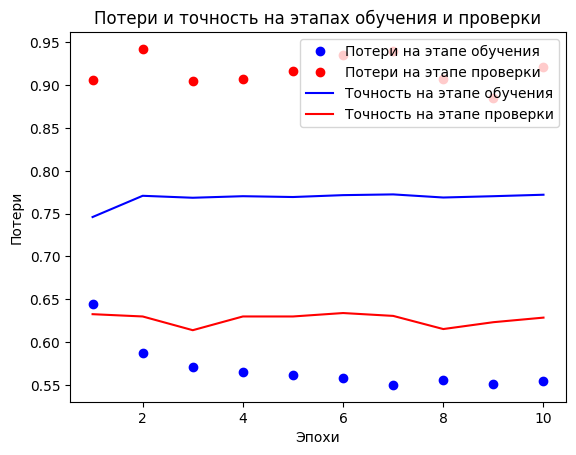

In [15]:
data.plot(history)

In [16]:
model_lstm_step2.load_weights(checkpoint_filepath)

In [20]:
export_model_lstm = tf.keras.Sequential([
  vectorize_layer,
  model_lstm_step2,
  tf.keras.layers.Activation('softmax')
])

export_model_lstm.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       698,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,115 (2.66 MB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 689,664 (2.63 MB)

In [18]:
model_lstm_step2.evaluate(
    test_ds_batch,
)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - F1Score: 0.5895 - accuracy: 0.6154 - loss: 0.9818


[0.9725853800773621,
 0.6193333268165588,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.72261477, 0.36086398, 0.6993524 ], dtype=float32)>]

In [21]:
export_model_lstm.save('models/kinopoisk_export_model_lstm.keras')

In [22]:
raw_tab_train_ds, raw_tab_valid_ds, raw_tab_test_ds = data.load('tabiturient')

Проверяем на данных tabiturient

In [30]:
tab_test_ds = data.vectorize(raw_tab_test_ds, vectorize_layer).batch(64)

In [31]:
model_lstm_step2.evaluate(
    tab_test_ds
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - F1Score: 0.3895 - accuracy: 0.4991 - loss: 1.4116


[1.3812592029571533,
 0.5083333253860474,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.6834862 , 0.25165558, 0.22556388], dtype=float32)>]